# DL training

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df=pd.read_parquet('train/pspa_t5.parquet')

In [5]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

pspa_info = pd.DataFrame(df.index.tolist(),columns=['kinase'])

pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)
pspa_info['family'] = pspa_info.kinase.map(family_map)
pspa_info['group'] = pspa_info.kinase.map(group_map)

In [6]:
df=df.reset_index()

In [7]:
df.columns

Index(['index', '-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1255)

In [8]:
# column name of feature and target
feat_col = df.columns[df.columns.str.startswith('T5_')]
target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [9]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

## Split

In [10]:
pspa_info

,kinase,subfamily,family,group
0,Q2M2I8_AAK1_HUMAN_KD1,NAK,NAK,Other
1,P27037_AVR2A_HUMAN_KD1,STKR2,STKR,TKL
2,Q13705_AVR2B_HUMAN_KD1,STKR2,STKR,TKL
3,P31749_AKT1_HUMAN_KD1,Akt,Akt,AGC
4,P31751_AKT2_HUMAN_KD1,Akt,Akt,AGC
...,...,...,...,...
363,P17948_VGFR1_HUMAN_KD1,VEGFR,VEGFR,TK
364,P35968_VGFR2_HUMAN_KD1,VEGFR,VEGFR,TK
365,P35916_VGFR3_HUMAN_KD1,VEGFR,VEGFR,TK
366,P07947_YES_HUMAN_KD1,Src,Src,TK


In [11]:
pspa_info.subfamily.value_counts()

subfamily
Eph      12
Src      11
NEK      10
CK1       7
STE11     7
         ..
ZAK       1
Sev       1
Ret       1
Musk      1
Tie       1
Name: count, Length: 149, dtype: int64

In [12]:
pspa_info.family.value_counts()

family
STE20    27
CAMKL    20
CDK      17
MAPK     12
Eph      12
         ..
STK33     1
Sev       1
Ret       1
Musk      1
Tie       1
Name: count, Length: 92, dtype: int64

In [13]:
pspa_info.group.value_counts()

group
TK          78
CAMK        57
CMGC        52
AGC         52
Other       49
STE         39
TKL         25
CK1         11
Atypical     5
Name: count, dtype: int64

In [14]:
splits = get_splits(pspa_info, group='group',nfold=9)

split0 = splits[0]

GroupKFold(n_splits=9, random_state=None, shuffle=False)
# group in train set: 8
# group in test set: 1


In [15]:
# splits = get_splits(pspa_info, stratified='subfamily',nfold=5)

# split0 = splits[0]

## Dataset

In [16]:
# dataset
ds = GeneralDataset(df,feat_col,target_col)

In [17]:
len(ds)

368

In [18]:
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [19]:
xb,yb = next(iter(dl))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Model

In [20]:
n_feature = len(feat_col)
n_target = len(target_col)

In [21]:

# def get_mlp(): return PSSM_model(n_feature,n_target,model='MLP')

def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [22]:
model = get_cnn()

In [23]:
logits= model(xb)

In [24]:
logits.shape

torch.Size([64, 23, 10])

## Loss

In [25]:
CE(logits,yb)

tensor(3.3157, grad_fn=<MeanBackward0>)

## Metrics

In [26]:
KLD(logits,yb)

tensor(0.5744, grad_fn=<MeanBackward0>)

In [27]:
JSD(logits,yb)

tensor(0.1175, grad_fn=<MeanBackward0>)

## CV train
> cross-validation

In [28]:
oof = train_dl_cv(df,feat_col,target_col,
                  splits = splits,
                  model_func = get_cnn,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.268444,3.142246,0.403685,0.081316,00:01
1,3.223688,3.149258,0.410697,0.083241,00:00
2,3.188168,3.216283,0.477722,0.098031,00:00
3,3.167378,3.243132,0.504571,0.099265,00:00
4,3.144057,3.275403,0.536842,0.095989,00:00
5,3.114893,3.410244,0.671683,0.100262,00:00
6,3.074008,3.487147,0.748586,0.101024,00:00
7,3.031979,3.477169,0.738607,0.096292,00:00
8,2.993206,3.545956,0.807395,0.096798,00:00
9,2.960338,3.564420,0.825859,0.094984,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.212596,3.125234,0.365841,0.080777,00:00
1,3.099743,2.987252,0.227859,0.057471,00:00
2,3.028379,2.910491,0.151098,0.035196,00:00
3,2.983666,2.890877,0.131483,0.031097,00:00
4,2.958514,2.905223,0.145831,0.034603,00:00
5,2.937688,2.907677,0.148284,0.035187,00:00
6,2.917891,2.881277,0.121884,0.028526,00:00
7,2.902501,2.873248,0.113856,0.026346,00:00
8,2.889619,2.872829,0.113436,0.026833,00:00
9,2.876809,2.887587,0.128195,0.030063,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.201890,3.129725,0.413121,0.088565,00:00
1,3.096505,2.986097,0.269494,0.064398,00:00
2,3.024636,2.871009,0.154406,0.034690,00:00
3,2.983121,2.886567,0.169964,0.038075,00:00
4,2.959250,2.890949,0.174346,0.038998,00:00
5,2.941066,2.876140,0.159536,0.036203,00:00
6,2.921443,2.835120,0.118516,0.027477,00:00
7,2.902086,2.833801,0.117198,0.027021,00:00
8,2.886297,2.849355,0.132751,0.031030,00:00
9,2.872198,2.838046,0.121443,0.028281,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.210961,3.139824,0.448681,0.093272,00:00
1,3.106327,3.012952,0.321808,0.073645,00:00
2,3.030328,2.910798,0.219654,0.045596,00:00
3,2.987636,2.923931,0.232787,0.046931,00:00
4,2.964270,2.944966,0.253822,0.050667,00:00
5,2.948700,2.925189,0.234045,0.046503,00:00
6,2.931691,2.939810,0.248666,0.045506,00:00
7,2.914931,2.940639,0.249495,0.047098,00:00
8,2.898672,2.933232,0.242088,0.047175,00:00
9,2.884794,2.956458,0.265314,0.049401,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.196200,3.119887,0.330442,0.073580,00:00
1,3.087657,2.964468,0.175023,0.045915,00:00
2,3.015391,2.924397,0.134952,0.031747,00:00
3,2.975794,2.941341,0.151896,0.036996,00:00
4,2.952074,2.949593,0.160148,0.036979,00:00
5,2.932781,2.909102,0.119657,0.027549,00:00
6,2.918698,2.904258,0.114813,0.026776,00:00
7,2.902740,2.904986,0.115541,0.026143,00:00
8,2.886056,2.899910,0.110465,0.025574,00:00
9,2.870191,2.908465,0.119020,0.027412,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.202535,3.133806,0.344995,0.074940,00:00
1,3.082218,2.982566,0.193756,0.050027,00:00
2,3.006975,2.907805,0.118994,0.029505,00:00
3,2.968001,2.898707,0.109897,0.026889,00:00
4,2.942980,2.903838,0.115027,0.028515,00:00
5,2.928590,2.907330,0.118519,0.029355,00:00
6,2.912098,2.913329,0.124519,0.030202,00:00
7,2.894329,2.910470,0.121659,0.028849,00:00
8,2.877685,2.888602,0.099792,0.024228,00:00
9,2.862452,2.881307,0.092496,0.022344,00:00


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.192896,3.114355,0.299088,0.068949,00:00
1,3.072716,2.940627,0.125361,0.032834,00:00
2,3.002883,2.957772,0.142506,0.032054,00:00
3,2.965346,2.990824,0.175558,0.039582,00:00
4,2.947776,2.941978,0.126711,0.029788,00:00
5,2.927652,2.913775,0.098509,0.023201,00:00
6,2.908386,2.931125,0.115859,0.028092,00:00
7,2.889489,3.015131,0.199864,0.040331,00:00
8,2.872598,3.108600,0.293334,0.047089,00:00
9,2.857689,3.067801,0.252534,0.044772,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.194380,3.124522,0.462477,0.099525,00:00
1,3.080183,2.939694,0.277649,0.062830,00:00
2,3.008529,2.995437,0.333392,0.067260,00:00
3,2.966992,3.179870,0.517824,0.101037,00:00
4,2.943557,3.033656,0.371611,0.072248,00:00
5,2.922162,2.979683,0.317637,0.068355,00:00
6,2.901323,2.962018,0.299973,0.067776,00:00
7,2.883021,2.956265,0.294219,0.069029,00:00
8,2.867451,2.959171,0.297125,0.067800,00:00
9,2.854755,2.945670,0.283625,0.063334,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.205244,3.132634,0.334502,0.072238,00:00
1,3.086741,2.955719,0.157587,0.037971,00:00
2,3.008643,2.943120,0.144988,0.031750,00:00
3,2.969967,2.987414,0.189282,0.040906,00:00
4,2.948977,2.929822,0.131690,0.028453,00:00
5,2.927054,2.913363,0.115232,0.025012,00:00
6,2.906929,2.917409,0.119277,0.025490,00:00
7,2.887527,2.905146,0.107015,0.022281,00:00
8,2.870863,2.904804,0.106672,0.022261,00:00
9,2.856507,2.907104,0.108972,0.022985,00:00


In [29]:
oof

,-5P,-4P,-3P,-2P,-1P,0P,1P,2P,3P,4P,...,-4pY,-3pY,-2pY,-1pY,0pY,1pY,2pY,3pY,4pY,nfold
0,0.047404,0.037780,0.046546,0.044617,0.051374,0.000030,0.017466,0.040908,0.049329,0.048131,...,0.039294,0.043213,0.046592,0.054406,0.000007,0.046097,0.046917,0.047657,0.034369,4
1,0.037532,0.045341,0.036718,0.063372,0.041851,0.000013,0.063370,0.025355,0.043444,0.038740,...,0.044952,0.052067,0.050859,0.034687,0.000006,0.031059,0.048092,0.029954,0.033546,6
2,0.035738,0.046827,0.036026,0.060344,0.043486,0.000012,0.063726,0.026826,0.046667,0.037928,...,0.039262,0.045940,0.043723,0.029287,0.000005,0.028443,0.042542,0.027091,0.031485,6
3,0.047568,0.048670,0.038904,0.052459,0.046462,0.000046,0.093580,0.036871,0.048124,0.043455,...,0.034359,0.029111,0.025172,0.045547,0.000052,0.046661,0.049495,0.048516,0.043920,2
4,0.049045,0.050830,0.037948,0.048573,0.048902,0.000038,0.079036,0.037306,0.045473,0.043417,...,0.031548,0.026048,0.023077,0.043740,0.000018,0.046211,0.049728,0.047716,0.042058,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,0.042055,0.046076,0.038341,0.050882,0.030014,0.000300,0.018654,0.027171,0.033283,0.051083,...,0.042263,0.052389,0.051906,0.054458,0.000377,0.027612,0.027426,0.034722,0.031342,0
364,0.042847,0.046771,0.039154,0.053156,0.032173,0.000260,0.022034,0.026839,0.036783,0.050359,...,0.040027,0.051253,0.047015,0.052011,0.000327,0.026737,0.025064,0.033250,0.031438,0
365,0.047013,0.045912,0.042460,0.065080,0.036413,0.000344,0.034923,0.027760,0.040243,0.050786,...,0.035882,0.045143,0.035541,0.047225,0.000414,0.021267,0.023076,0.027955,0.025657,0
366,0.045561,0.050462,0.050171,0.067506,0.022177,0.000440,0.022360,0.025587,0.037392,0.056982,...,0.046249,0.049369,0.045894,0.056376,0.000457,0.028827,0.025201,0.032906,0.029250,0


## Score

In [30]:
from katlas.clustering import *

from functools import partial

In [31]:
def score_df(target,pred,func):
    distance = [func(target.loc[i],pred.loc[i,target.columns]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [32]:
jsd_df = partial(score_df,func=js_divergence_flat)
kld_df = partial(score_df,func=kl_divergence_flat)

In [33]:
target=df[target_col].copy()

In [34]:
pspa_info['group_split'] = oof.nfold

In [35]:
pspa_info['group_jsd'] =jsd_df(target,oof)

In [36]:
from katlas.plot import *

In [37]:
plot_bar

<function katlas.plot.plot_bar(df, value, group, title=None, figsize=(12, 5), fontsize=14, dots=True, rotation=90, ascending=False, *, data=None, x=None, y=None, hue=None, order=None, hue_order=None, estimator='mean', errorbar=('ci', 95), n_boot=1000, seed=None, units=None, weights=None, orient=None, color=None, palette=None, saturation=0.75, fill=True, hue_norm=None, width=0.8, dodge='auto', gap=0, log_scale=None, native_scale=False, formatter=None, legend='auto', capsize=0, err_kws=None, ci=<deprecated>, errcolor=<deprecated>, errwidth=<deprecated>, ax=None)>

In [38]:
len(pspa_info)

368

In [39]:
set_sns()

Text(0.5, 1.0, 'Leave-one-group-out in kinase group')

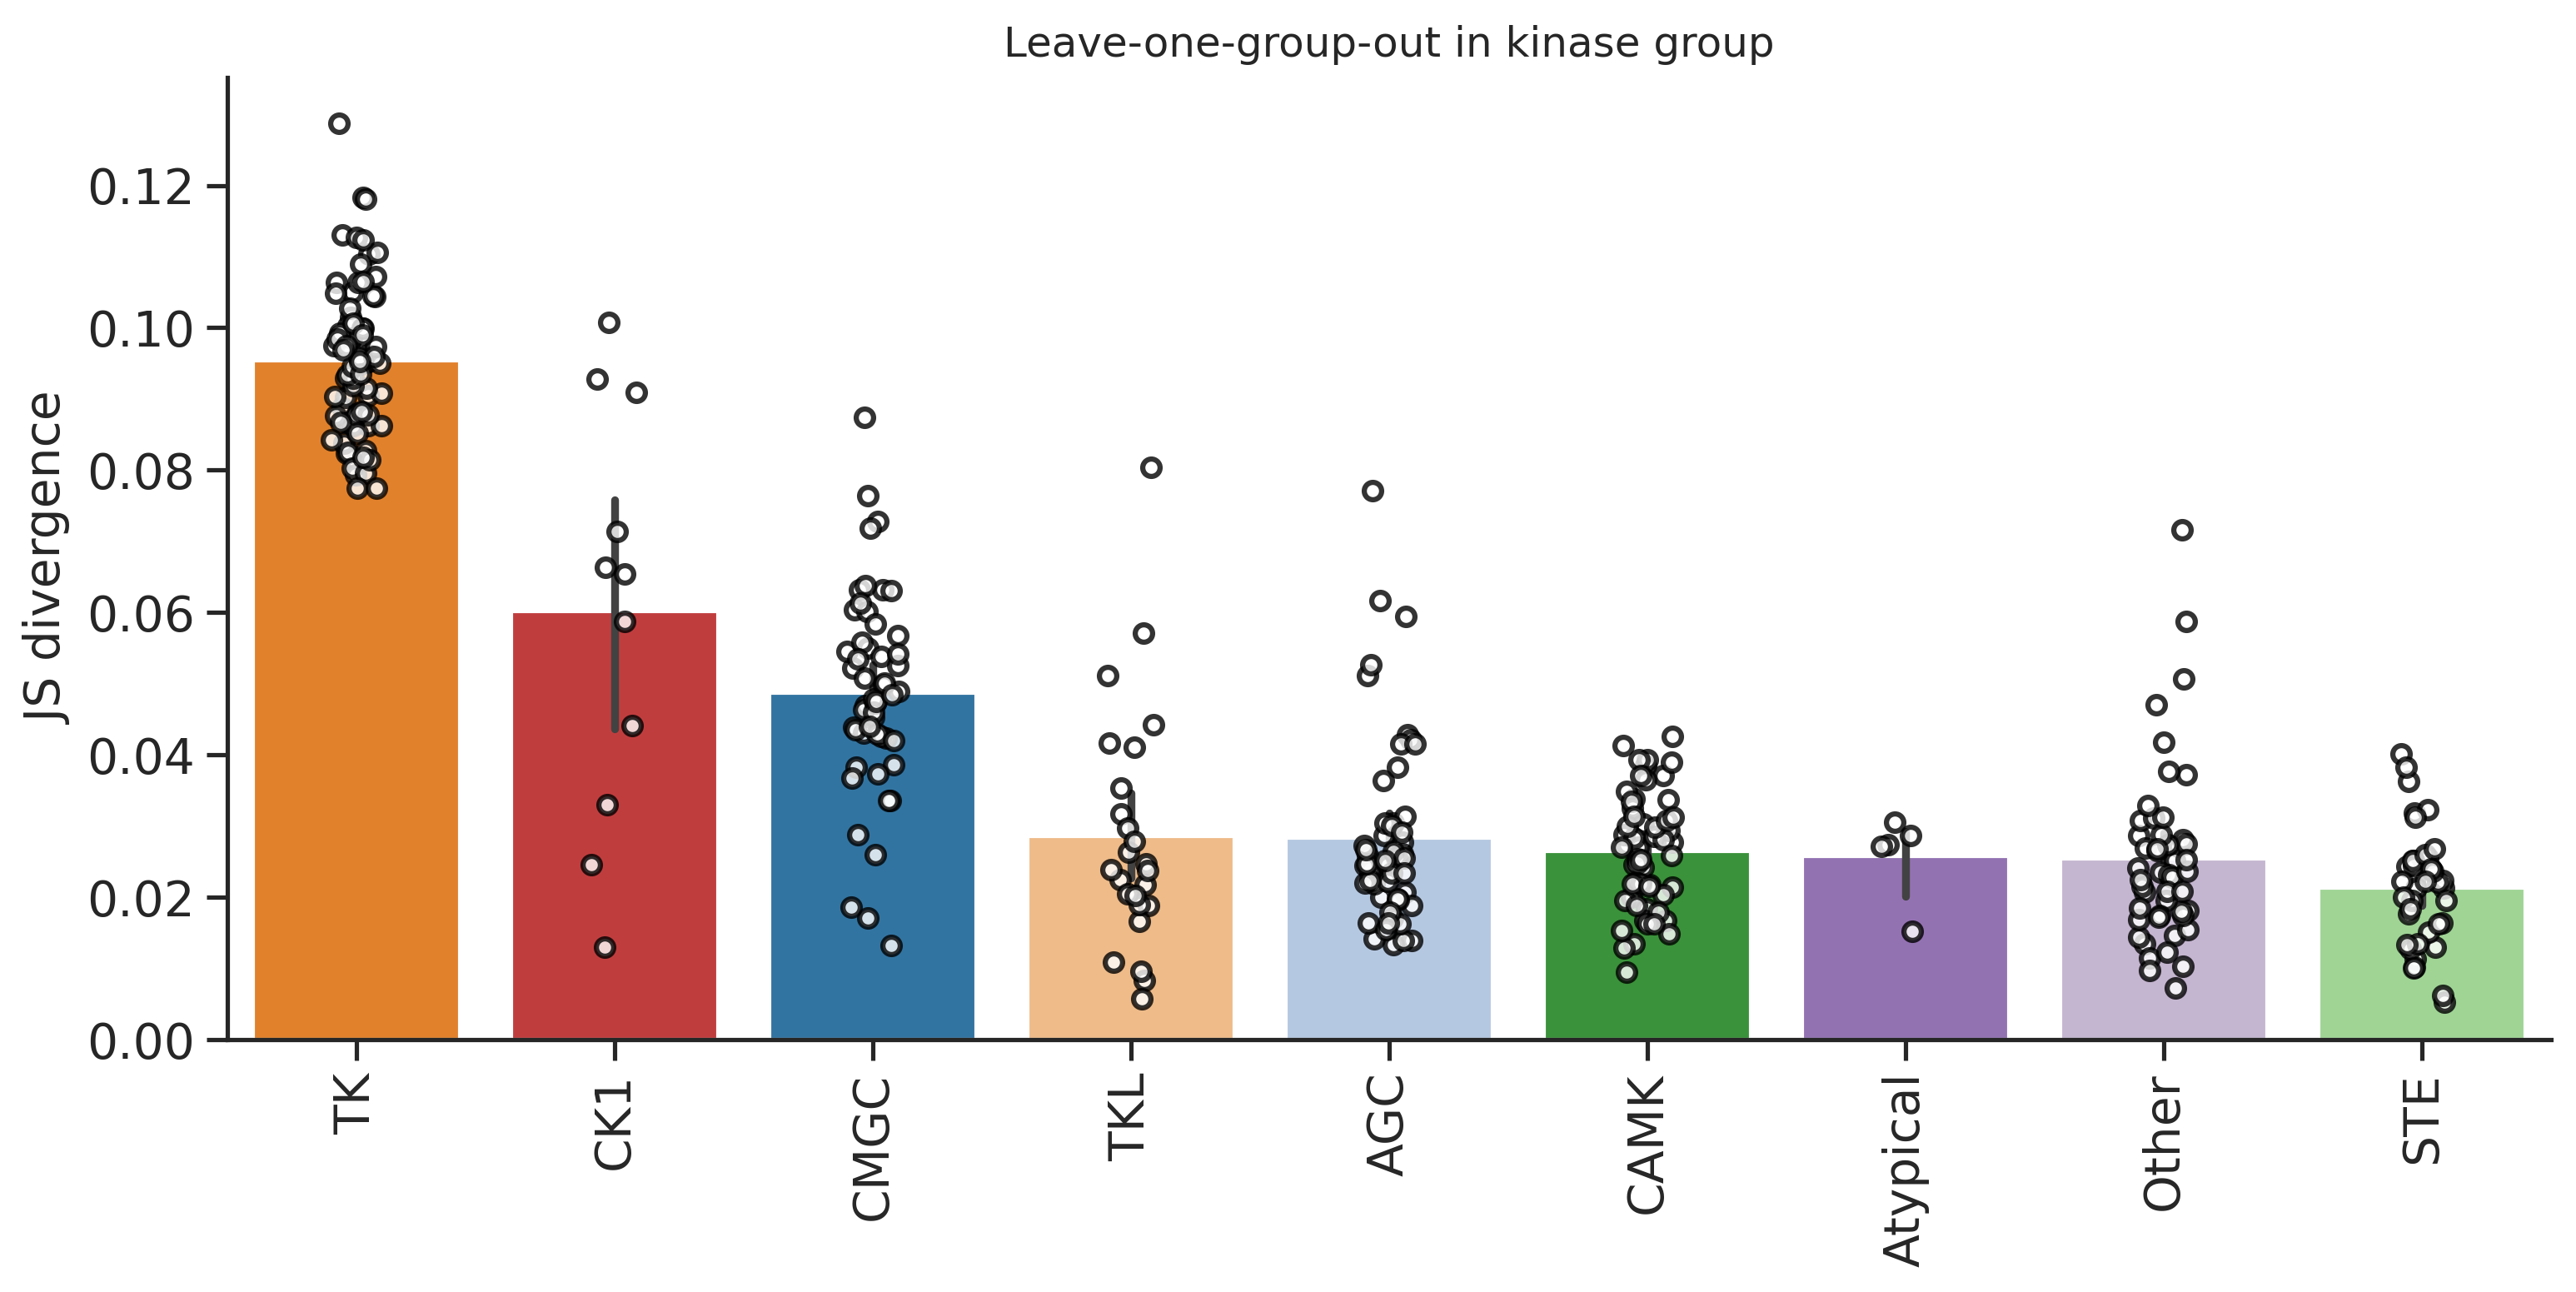

In [40]:
plot_bar(pspa_info,'group_jsd',group='group',palette=group_color)
plt.ylabel('JS divergence')
plt.title('Leave-one-group-out in kinase group')

In [41]:
pspa_info.sort_values('group_jsd')

,kinase,subfamily,family,group,group_split,group_jsd
143,Q13163_MP2K5_HUMAN_KD1,STE7,STE7,STE,5,0.005204
20,Q13873_BMPR2_HUMAN_KD1,STKR2,STKR,TKL,6,0.005647
144,Q13233_M3K1_HUMAN_KD1,STE11,STE11,STE,5,0.006119
174,Q8NG66_NEK11_HUMAN_KD1,NEK,NEK,Other,4,0.007180
10,P57078_RIPK4_HUMAN_KD1,RIPK,RIPK,TKL,6,0.008301
...,...,...,...,...,...,...
323,P22455_FGFR4_HUMAN_KD1,FGFR,FGFR,TK,0,0.112695
317,Q05397_FAK1_HUMAN_KD1,FAK,FAK,TK,0,0.113066
353,P43405_KSYK_HUMAN_KD1,Syk,Syk,TK,0,0.118080
319,P07332_FES_HUMAN_KD1,Fer,Fer,TK,0,0.118289


In [45]:
from katlas.pssm import *

In [46]:
def plot_one_pssm(target,pred,idx):
    target_pssm = recover_pssm(target.loc[idx])
    pred_pssm = recover_pssm(pred.loc[idx,target.columns])
    plot_heatmap(target_pssm)
    plot_heatmap(pred_pssm)

In [47]:
set_sns(50)

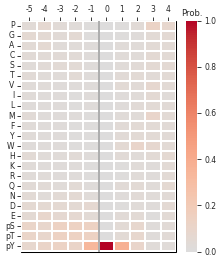

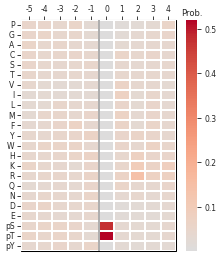

In [48]:
plot_one_pssm(target,oof,367)